# IO 2, Problem Set 3

#### Abram and Higbee

In [478]:
# Set wd
pwd()
dir = "/Users/JoshuaHigbee/Box/2. Second Year/2. Winter Quarter - 2021/" * 
        "Industrial Organization II - Hortacsu/Problem Sets/Problem Set 3/";
cd(dir);

# Set up packages (must have pre-loaded)
using Pkg
using CSV, DataFrames, Random, Distributions, LinearAlgebra, LatexPrint, StatsBase, Plots, SpecialFunctions
using Optim, ForwardDiff, PyCall, ShiftedArrays, StatsPlots, DataFramesMeta, FixedEffectModels, QuadGK

# Set seed
Random.seed!(12345);

# Set column and row views
#ENV["COLUMNS"]=10000; ENV["ROWS"]=10000;
Base.displaysize() = (100, 100000);

<br><br><br><br>

# 1. Data

In [925]:
dt = CSV.read("ps3clean.csv", DataFrame);
println(size(dt))

(2636, 21)


In [926]:
rename!(dt, [:data_num, :bidder, :house, :date, :lot, :profit, :net_pay, :rank, :p_final, :bid,
                :est_min_d, :est_max_d, :catalog_p, :catalog_d, :est_min, :est_max, :grade_min,
                :grade_max, :no_grade, :excl_us, :no_value]);

In [927]:
dt = dt[ismissing.(dt.grade_min) .== 0, :];
size(dt)

(2635, 21)

In [928]:
dt.auction_num = groupindices(groupby(dt, [:house, :date, :lot, :p_final]));

In [929]:
dt[!, :num_bidders] .= 0
for i in unique(dt.auction_num)
    dt[dt.auction_num .== i, :num_bidders] .= nrow(dt[dt.auction_num .== i, :])
end;

In [930]:
dt.lot_value = 0.5 .* (dt.est_min .+ dt.est_max);

In [931]:
first(dt, 10)

,data_num,bidder,house,date,lot,profit,net_pay,rank,p_final,bid,est_min_d,est_max_d,catalog_p,catalog_d,est_min,est_max,grade_min,grade_max,no_grade,excl_us,no_value,auction_num,num_bidders,lot_value
,Int64,Int64,String,Int64,String,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,Int64?,Int64,Int64,Int64,Int64,Int64?,Int64,Float64
1,1,1,A,35360,217,150.0,-150.0,1,5200,8000,7000,9000,0.0,0,7000.0,9000.0,3,2,0,1,0,1,2,8000.0
2,2,2,A,35360,217,150.0,150.0,2,5200,5500,7000,9000,0.0,0,7000.0,9000.0,3,2,0,1,0,1,2,8000.0
3,3,1,A,35360,218,0.0,0.0,1,1000,950,300,400,0.0,0,300.0,400.0,5,2,0,1,0,2,1,350.0
4,4,1,A,35360,220,0.0,0.0,1,1500,1500,1000,1200,0.0,0,1000.0,1200.0,5,2,0,1,0,3,1,1100.0
5,5,1,A,35360,222,0.0,0.0,1,4800,4750,4000,5000,0.0,0,4000.0,5000.0,3,2,0,1,0,4,1,4500.0
6,6,1,A,35360,350,0.0,0.0,1,2200,2100,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
7,7,2,A,35360,350,0.0,0.0,2,2200,1700,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
8,8,3,A,35360,350,0.0,0.0,3,2200,1050,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
9,9,1,A,35360,351,0.0,0.0,1,1400,550,1000,1200,0.0,0,1000.0,1200.0,2,2,0,0,0,6,1,1100.0


<br><br>

### Table 1

In [932]:
houses = unique(dt.house)
tab_1 = DataFrame(house = houses, tgt_mean = fill(0,6), tgt_sd = fill(0,6), knock_mean = fill(0,6), 
    knock_sd = fill(0,6), perc_lots_won = fill(0,6), perc_val_won = fill(0,6), num_lots = fill(0,6), 
    num_sales = fill(0,6))

for house in houses

    # Get data
    dt_h = dt[dt.house .== house, :]
    dt_h1 = dt_h[dt_h.rank .== 1, :]
    
    # Target auction values
    tab_1[tab_1.house .== house, :tgt_mean] .= Int(round(mean(dt_h1.p_final), digits=0))
    tab_1[tab_1.house .== house, :tgt_sd] .= Int(round(std(dt_h1.p_final), digits=0))
    
    # Knockout auction values
    tab_1[tab_1.house .== house , :knock_mean] .= 
        Int(round(mean(dt_h[:, :bid]), digits=0))
    tab_1[tab_1.house .== house, :knock_sd] .= 
        Int(round(std(dt_h[:, :bid]), digits=0))
    
    # Perc of lots/value won by ring
    tab_1[tab_1.house .== house , :perc_lots_won] .= 
        Int(round.(mean(100*(dt_h1.bid .≥ dt_h1.p_final)), digits=0))
    tab_1[tab_1.house .== house , :perc_val_won] .= 
        Int(round.(100*sum(dt_h1[dt_h1.bid .≥ dt_h1.p_final, :lot_value])/sum(dt_h1.lot_value), digits=0))
    
    # Number of lots and sales
    tab_1[tab_1.house .== house , :num_lots] .= nrow(dt_h1)
    tab_1[tab_1.house .== house , :num_sales] .= length(unique(dt_h1.date))
end;

In [933]:
row =  DataFrame(house = "Aggregate", tgt_mean = fill(0,1), tgt_sd = fill(0,1), knock_mean = fill(0,1), 
    knock_sd = fill(0,1), perc_lots_won = fill(0,1), perc_val_won = fill(0,1), num_lots = fill(0,1), 
    num_sales = fill(0,1))
dt_r1 = dt[dt.rank .== 1, :]
row.house = "Aggregate"
row.tgt_mean = Int(round(mean(dt_r1.p_final), digits=0))
row.tgt_sd = Int(round(std(dt_r1.p_final), digits=0))
row.knock_mean = Int(round(mean(dt_r1.bid), digits=0))
row.knock_sd = Int(round(std(dt_r1.bid), digits=0))
row.perc_lots_won = Int(round.(mean(100*(dt_r1.bid .≥ dt_r1.p_final)), digits=0))
row.perc_val_won = Int(round.(100*sum(dt_r1[dt_r1.bid .≥ dt_r1.p_final, :lot_value]) / 
                            sum(dt_r1.lot_value), digits=0))
row.num_lots = nrow(dt_r1)
row.num_sales = length(unique(dt_r1.date));

In [934]:
tab_1 = append!(tab_1, row)
tab_1

,house,tgt_mean,tgt_sd,knock_mean,knock_sd,perc_lots_won,perc_val_won,num_lots,num_sales
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,A,1633,1692,1112,1560,28,48,29,1
2,B,1000,1454,1330,2757,65,43,37,1
3,C,951,1586,1385,2270,63,66,412,2
4,D,1084,1402,1327,1757,46,52,153,1
5,E,2904,3057,4220,4826,87,95,127,1
6,F1,1619,2562,1941,3706,48,61,100,2
7,Aggregate,1367,2082,2006,4023,60,74,858,8


In [1600]:
tabular(Matrix(tab_1))

\begin{tabular}{ccccccccc}
$\text{A}$ & $1633$ & $1692$ & $1112$ & $1560$ & $28$ & $48$ & $29$ & $1$\\
$\text{B}$ & $1000$ & $1454$ & $1330$ & $2757$ & $65$ & $43$ & $37$ & $1$\\
$\text{C}$ & $951$ & $1586$ & $1385$ & $2270$ & $63$ & $66$ & $412$ & $2$\\
$\text{D}$ & $1084$ & $1402$ & $1327$ & $1757$ & $46$ & $52$ & $153$ & $1$\\
$\text{E}$ & $2904$ & $3057$ & $4220$ & $4826$ & $87$ & $95$ & $127$ & $1$\\
$\text{F1}$ & $1619$ & $2562$ & $1941$ & $3706$ & $48$ & $61$ & $100$ & $2$\\
$\text{Aggregate}$ & $1367$ & $2082$ & $2006$ & $4023$ & $60$ & $74$ & $858$ & $8$
\end{tabular}


<br><br>

### Table 2

In [936]:
bid_nums = sort(unique(dt.num_bidders))
tab_2 = DataFrame(num_bids = bid_nums, tgt_mean = fill(0,8), tgt_sd = fill(0,8), knock_mean = fill(0,8), 
    knock_sd = fill(0,8), perc_lots_won = fill(0,8), num_lots = fill(0,8))

for bid in bid_nums

    # Get data
    dt_b = dt[dt.num_bidders .== bid, :]
    dt_b1 = dt_b[dt_b.rank .== 1, :]
    
    # Target auction values
    tab_2[tab_2.num_bids .== bid, :tgt_mean] .= Int(round(mean(dt_b1.p_final), digits=0))
    tab_2[tab_2.num_bids .== bid, :tgt_sd] .= Int(round(std(dt_b1.p_final), digits=0))
    
    # Knockout auction values
    tab_2[tab_2.num_bids .== bid, :knock_mean] .= 
        Int(round(mean(dt_b[:, :bid]), digits=0))
    tab_2[tab_2.num_bids .== bid, :knock_sd] .= 
        Int(round(std(dt_b[:, :bid]), digits=0))
    
    # Perc of lots/value won by ring
    tab_2[tab_2.num_bids .== bid, :perc_lots_won] .= 
        Int(round.(mean(100*(dt_b1.bid .≥ dt_b1.p_final)), digits=0))
    
    # Number of lots and sales
    tab_2[tab_2.num_bids .== bid, :num_lots] .= nrow(dt_b1)
end;

In [937]:
tab_2

,num_bids,tgt_mean,tgt_sd,knock_mean,knock_sd,perc_lots_won,num_lots
,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,568,863,498,900,29,266
2,2,991,1803,946,2800,59,149
3,3,1221,1512,1083,1605,68,127
4,4,2030,2825,2186,4352,77,110
5,5,1755,2331,1861,3157,84,79
6,6,2327,3145,2643,3934,89,55
7,7,2722,2053,3448,2972,96,51
8,8,4290,2556,5501,4009,95,21


<br><br><br><br>

# 2. Introductory Questions

### Table 5

In [938]:
first(dt, 10)

,data_num,bidder,house,date,lot,profit,net_pay,rank,p_final,bid,est_min_d,est_max_d,catalog_p,catalog_d,est_min,est_max,grade_min,grade_max,no_grade,excl_us,no_value,auction_num,num_bidders,lot_value
,Int64,Int64,String,Int64,String,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,Int64?,Int64,Int64,Int64,Int64,Int64?,Int64,Float64
1,1,1,A,35360,217,150.0,-150.0,1,5200,8000,7000,9000,0.0,0,7000.0,9000.0,3,2,0,1,0,1,2,8000.0
2,2,2,A,35360,217,150.0,150.0,2,5200,5500,7000,9000,0.0,0,7000.0,9000.0,3,2,0,1,0,1,2,8000.0
3,3,1,A,35360,218,0.0,0.0,1,1000,950,300,400,0.0,0,300.0,400.0,5,2,0,1,0,2,1,350.0
4,4,1,A,35360,220,0.0,0.0,1,1500,1500,1000,1200,0.0,0,1000.0,1200.0,5,2,0,1,0,3,1,1100.0
5,5,1,A,35360,222,0.0,0.0,1,4800,4750,4000,5000,0.0,0,4000.0,5000.0,3,2,0,1,0,4,1,4500.0
6,6,1,A,35360,350,0.0,0.0,1,2200,2100,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
7,7,2,A,35360,350,0.0,0.0,2,2200,1700,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
8,8,3,A,35360,350,0.0,0.0,3,2200,1050,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
9,9,1,A,35360,351,0.0,0.0,1,1400,550,1000,1200,0.0,0,1000.0,1200.0,2,2,0,0,0,6,1,1100.0


In [939]:
bidders = sort(unique(dt.bidder))
tab_5 = DataFrame(ring_member = bidders, perc_high = fill(0,11), num_knock = fill(0,11), 
    perc_high_p2 = fill(0,11), perc_rec_sp_p2 = fill(0,11), perc_pay_sp_p2 = fill(0,11), 
    num_knock_p2 = fill(0,11))

for bidder in bidders

    # Get data
    dt_b = dt[dt.bidder .== bidder, :]
    dt_b_p2 = dt_b[(dt_b.bidder .== bidder) .& (dt_b.num_bidders .≥ 2), :]
    
    # All auctions
    tab_5[tab_5.ring_member .== bidder, :perc_high] .= 
        Int(round.(mean(100*(dt_b.rank .== 1)), digits=0))
    tab_5[tab_5.ring_member .== bidder, :num_knock] .= nrow(dt_b)
        # Int(round.(sum((dt_b.rank .== 1)), digits=0))
    
    # All auctions
    tab_5[tab_5.ring_member .== bidder, :perc_high_p2] .= 
        Int(round.(mean(100*(dt_b_p2.rank .== 1)), digits=0))
    tab_5[tab_5.ring_member .== bidder, :perc_rec_sp_p2] .= 
        Int(round.(mean(100*(dt_b_p2.net_pay .> 0)), digits=0))
    tab_5[tab_5.ring_member .== bidder, :perc_pay_sp_p2] .= 
        Int(round.(mean(100*(dt_b_p2.net_pay .< 0)), digits=0))
    tab_5[tab_5.ring_member .== bidder, :num_knock_p2] .= nrow(dt_b_p2)
        # Int(round.(sum((dt_b_p2.rank .== 1)), digits=0))
end;

In [940]:
tab_5

,ring_member,perc_high,num_knock,perc_high_p2,perc_rec_sp_p2,perc_pay_sp_p2,num_knock_p2
,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,40,652,24,23,8,517
2,2,10,362,8,24,2,357
3,3,37,393,27,29,10,339
4,4,27,323,26,29,14,318
5,5,38,269,23,24,6,219
6,6,46,153,46,14,20,152
7,7,41,232,40,26,24,227
8,8,17,30,4,35,0,26
9,9,48,77,45,29,16,73


<br><br>

### Figure 1

In [941]:
bidders = sort(unique(dt.bidder))
fig_1_tab = DataFrame(ring_member = bidders, net_pay_all = fill(0.0,11), net_pay_small_auct = fill(0.0,11))

for bidder in bidders

    # Get data
    dt_b = dt[dt.bidder .== bidder, :]
    dt_b_sa = dt_b[(dt_b.bidder .== bidder) .& (dt_b.p_final .≤ 10000), :]
    
    # All auctions
    fig_1_tab[tab_5.ring_member .== bidder, :net_pay_all] .= sum(dt_b.net_pay)
    fig_1_tab[tab_5.ring_member .== bidder, :net_pay_small_auct] .= sum(dt_b_sa.net_pay)
end;

In [942]:
fig_1_tab

,ring_member,net_pay_all,net_pay_small_auct
,Int64,Float64,Float64
1,1,12882.2,16132.2
2,2,8590.73,7507.4
3,3,14588.5,12234.3
4,4,-7078.9,-7933.07
5,5,1463.14,1463.14
6,6,-4806.73,-4806.73
7,7,-53016.2,-37016.2
8,8,880.31,880.31
9,9,5478.21,-6480.12


In [943]:
payments = vec(reshape(Matrix(fig_1_tab[:, [:net_pay_all, :net_pay_small_auct]]), 22, 1));
auct_type = repeat(["All Auctions", "Small Auctions (<\$10k) "], inner=11);
names = repeat([" 1", " 2", " 3", " 4", " 5", " 6", " 7", " 8", " 9", "10", "11"], outer = 2);

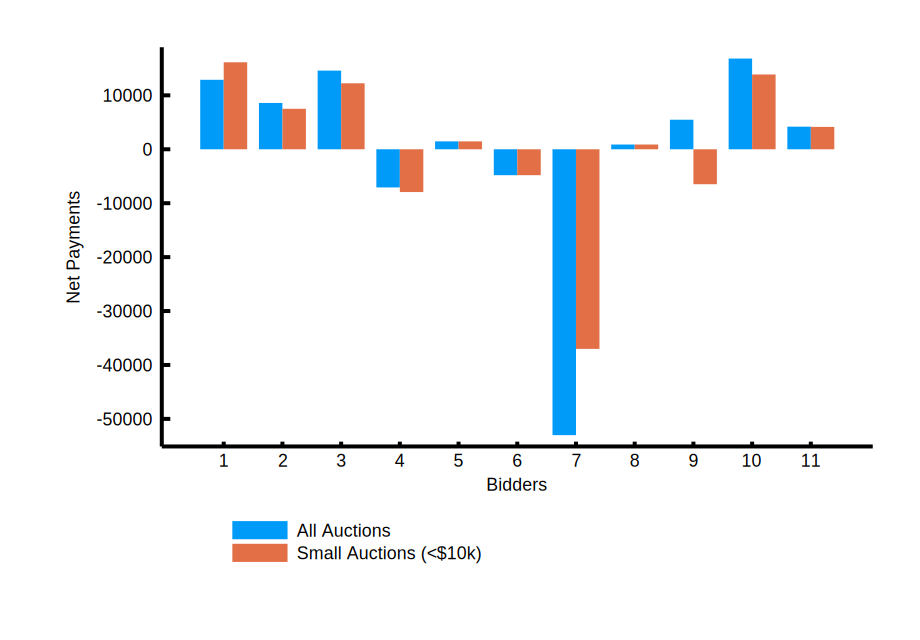

In [944]:
fig = groupedbar(names, payments, group = auct_type, ylabel = "Net Payments", title = "",
        legendfont=font(3), guidefont=font(3), xtickfont=font(3), ytickfont=font(3), line=0,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false,
        legend=:outerbottom, xlabel = "Bidders", yformatter = :plain)
plot!(size=(230,160))
savefig("fig_5.png")
fig

#### Remove auctions with more than 2 ring bidders

In [945]:
dt = dt[dt.num_bidders .≤ 2, :];

In [946]:
size(dt)

(564, 24)

<br><br><br><br>

# 3. Structural Analysis

## Step 1

### Normalize the bids

Predict bids

Normalize bids

In [1406]:
dt_b = dt[:, [:auction_num, :bidder, :rank, :bid, :p_final, :est_min, :est_max, 
                :catalog_p, :grade_min, :grade_max, :excl_us, :no_value]]
println(size(dt_b))
first(dt_b, 10)

(564, 12)


,auction_num,bidder,rank,bid,p_final,est_min,est_max,catalog_p,grade_min,grade_max,excl_us,no_value
,Int64?,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64?,Int64,Int64,Int64
1,1,1,1,8000,5200,7000.0,9000.0,0.0,3,2,1,0
2,1,2,2,5500,5200,7000.0,9000.0,0.0,3,2,1,0
3,2,1,1,950,1000,300.0,400.0,0.0,5,2,1,0
4,3,1,1,1500,1500,1000.0,1200.0,0.0,5,2,1,0
5,4,1,1,4750,4800,4000.0,5000.0,0.0,3,2,1,0
6,6,1,1,550,1400,1000.0,1200.0,0.0,2,2,0,0
7,7,1,1,340,200,300.0,400.0,0.0,3,2,0,0
8,9,2,1,120,130,180.0,200.0,0.0,3,2,0,0
9,12,1,1,300,850,350.0,450.0,0.0,3,2,0,0


Flag auctions where ring wins

In [1407]:
dt_b[:, :ring_wins] .= 0.0
for i in unique(dt_b.auction_num)
    dt_b[dt_b.auction_num .== i, :ring_wins] .= 1.0*(dt_b[(dt_b.auction_num .== i) .& (dt_b.rank .== 1), 
            :p_final] .< dt_b[(dt_b.auction_num .== i) .& (dt_b.rank .== 1), :bid])
end;

In [1408]:
for i in unique(dt_b.auction_num)
    row = dt_b[(dt_b.auction_num .== i) .& (dt_b.rank .== 1), :]
    row[2] = 100
    row[4] = row[5]
    append!(dt_b, row)
end;
dt_b = sort!(dt_b, [:auction_num, :bidder])
dt_b[:, :log_bid] = log.(dt_b.bid)
println(size(dt_b))
first(dt_b, 10)

(979, 14)


,auction_num,bidder,rank,bid,p_final,est_min,est_max,catalog_p,grade_min,grade_max,excl_us,no_value,ring_wins,log_bid
,Int64?,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64?,Int64,Int64,Int64,Float64,Float64
1,1,1,1,8000,5200,7000.0,9000.0,0.0,3,2,1,0,1.0,8.9872
2,1,2,2,5500,5200,7000.0,9000.0,0.0,3,2,1,0,1.0,8.6125
3,1,100,1,5200,5200,7000.0,9000.0,0.0,3,2,1,0,1.0,8.55641
4,2,1,1,950,1000,300.0,400.0,0.0,5,2,1,0,0.0,6.85646
5,2,100,1,1000,1000,300.0,400.0,0.0,5,2,1,0,0.0,6.90776
6,3,1,1,1500,1500,1000.0,1200.0,0.0,5,2,1,0,0.0,7.31322
7,3,100,1,1500,1500,1000.0,1200.0,0.0,5,2,1,0,0.0,7.31322
8,4,1,1,4750,4800,4000.0,5000.0,0.0,3,2,1,0,0.0,8.4659
9,4,100,1,4800,4800,4000.0,5000.0,0.0,3,2,1,0,0.0,8.47637


Regression with dummies for bidders (including outside bidders) and each auction number

In [1409]:
b_reg = reg(dt_b, @formula(log_bid ~ est_min + est_max + catalog_p + grade_min + grade_max +
                    excl_us + no_value + fe(bidder) + fe(auction_num)))

                            Fixed Effect Model                            
Number of obs:                   979  Degrees of freedom:              434
R2:                            0.933  R2 Adjusted:                   0.879
F Statistic:             2.28681e-14  p-value:                       1.000
R2 within:                     0.000  Iterations:                       17
Converged:                      true  
              Estimate Std.Error     t value Pr(>|t|)  Lower 95% Upper 95%
--------------------------------------------------------------------------
est_min    -3.87254e-7   210.534 -1.83939e-9    1.000   -413.557   413.557
est_max    -1.83259e-5   237.981 -7.70055e-8    1.000   -467.473   467.473
catalog_p  0.000363332   2367.13   1.5349e-7    1.000   -4649.82   4649.82
grade_min    -0.301242  1.3707e6 -2.19772e-7    1.000 -2.69251e6 2.69251e6
grade_max   -0.0365619  207744.0 -1.75995e-7    1.000  -408077.0 4.08077e5
excl_us      -0.572701 3.15406e6 -1.81576e-7    1.000  -6.195

In [1410]:
b_reg.coef

7-element Array{Float64,1}:
 -3.872540876797245e-7
 -1.832586689762519e-5
  0.00036333196368808527
 -0.30124171489782786
 -0.03656188280629126
 -0.5727007415682426
  0.05299310122660763

Now running with "target auction" bidder and "individual ring members" dummies, so 12 total dummies.

In [1411]:
b_reg = reg(dt_b, @formula(log_bid ~ est_min + est_max + catalog_p + grade_min + grade_max +
                    excl_us + no_value + fe(bidder)), Vcov.robust())

                              Fixed Effect Model                              
Number of obs:                     979   Degrees of freedom:                 19
R2:                              0.480   R2 Adjusted:                     0.470
F Statistic:                   62.0586   p-value:                         0.000
R2 within:                       0.441   Iterations:                          1
Converged:                        true   
              Estimate   Std.Error   t value Pr(>|t|)    Lower 95%    Upper 95%
-------------------------------------------------------------------------------
est_min    0.000564641 0.000326536   1.72919    0.084  -7.61648e-5   0.00120545
est_max     4.30127e-5 0.000260421  0.165166    0.869 -0.000468047  0.000554073
catalog_p  -0.00041597  7.96043e-5  -5.22548    0.000 -0.000572189 -0.000259752
grade_min    0.0588739    0.020454   2.87836    0.004    0.0187342    0.0990135
grade_max   -0.0153202   0.0244956 -0.625428    0.532   -0.0633913    0.0327508

In [1412]:
b_reg.coef

7-element Array{Float64,1}:
  0.0005646411859012532
  4.301270745790618e-5
 -0.0004159703322504552
  0.058873861553100836
 -0.015320224813137592
 -0.014261378096007514
 -0.09270047994324666

In [1413]:
dt_b[:, :b_norm] = dt_b.log_bid .- Matrix(dt_b[:, [:est_min, :est_max, :catalog_p, :grade_min, :grade_max, 
                            :excl_us, :no_value]]) * b_reg.coef
dt_b.bhat = exp.(dt_b.b_norm)
first(dt_b, 10)

,auction_num,bidder,rank,bid,p_final,est_min,est_max,catalog_p,grade_min,grade_max,excl_us,no_value,ring_wins,log_bid,b_norm,bhat
,Int64?,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64?,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,1,1,1,8000,5200,7000.0,9000.0,0.0,3,2,1,0,1.0,8.9872,4.51587,91.4575
2,1,2,2,5500,5200,7000.0,9000.0,0.0,3,2,1,0,1.0,8.6125,4.14118,62.877
3,1,100,1,5200,5200,7000.0,9000.0,0.0,3,2,1,0,1.0,8.55641,4.08509,59.4474
4,2,1,1,950,1000,300.0,400.0,0.0,5,2,1,0,0.0,6.85646,6.4204,614.247
5,2,100,1,1000,1000,300.0,400.0,0.0,5,2,1,0,0.0,6.90776,6.47169,646.576
6,3,1,1,1500,1500,1000.0,1200.0,0.0,5,2,1,0,0.0,7.31322,6.4475,631.12
7,3,100,1,1500,1500,1000.0,1200.0,0.0,5,2,1,0,0.0,7.31322,6.4475,631.12
8,4,1,1,4750,4800,4000.0,5000.0,0.0,3,2,1,0,0.0,8.4659,5.86055,350.918
9,4,100,1,4800,4800,4000.0,5000.0,0.0,3,2,1,0,0.0,8.47637,5.87102,354.612


<br><br><br><br>

## Step 3

Determine evaluation grid for all distributions (using 50-1500 as the shared support, since it is approximately what is in the Asker paper and contains most of the points without having too thin support in some areas)

In [1557]:
evals_pts = LinRange(50,1500,2000);

Write kernel density estimation functions

In [1558]:
bw_silv = function(x)
    n = length(x)
    m = min(std(x), iqr(x)/1.349) 
    h = 0.9 * m / n^0.2
    return h
end;

In [1559]:
est_pdf = function(x, eval_pts)
    h = bw_silv(x)
    return 1 / (h * length(x)) * sum([pdf(Normal(), (eval_pts .- x_i) ./ h) for x_i in x])
end;

In [1560]:
est_cdf = function(x, eval_pts)
    h = bw_silv(x)
    return 1 / (length(x)) * sum([cdf(Normal(), (eval_pts .- x_i) ./ h) for x_i in x])
end;

### Estimate $\bar{H}_r$

In [1561]:
# Highest (normalized) bid when the ring wins (equal to observed bids by non-ring bidders)
dt_r1 = dt_b[(dt_b.rank .== 1) .& (dt_b.bidder .< 100), :]
H̄r_bids_obs = dt_r1[dt_r1.p_final .< dt_r1.bid, :bhat];
#H̄r_bids_obs = dt_r1[dt_r1.p_final .< dt_r1.bhat, :p_final];

H̄r_bids_obs = dt_b[(dt_b.bidder .== 100) .& (dt_b.ring_wins .== 1.0), :bhat]

# H̄r_bids_obs = dt_b[(dt_b.bidder .== 100) .& (dt_b.ring_wins .== 1.0), :bhat]
# H̄r_bids_obs = dt_b[(dt_b.bidder .!= 100) .& (dt_b.rank .== 1) .& (dt_b.p_final .< dt_b.bid), :bhat];
# H̄r_bids_obs = dt_b[(dt_b.bidder .== 100) .& (dt_b.p_final .< dt_b.bid), :bhat];
# H̄r_bids_obs = dt_b[(dt_b.bidder .!= 100) .& (dt_b.rank .== 1) .& (dt_b.ring_wins .== 1), :bhat];
# H̄r_bids_obs = dt_b[(dt_b.bidder .== 100) .& (dt_b.ring_wins .== 1), :p_final];

In [1562]:
pdf_H̄r = est_pdf(H̄r_bids_obs, evals_pts);

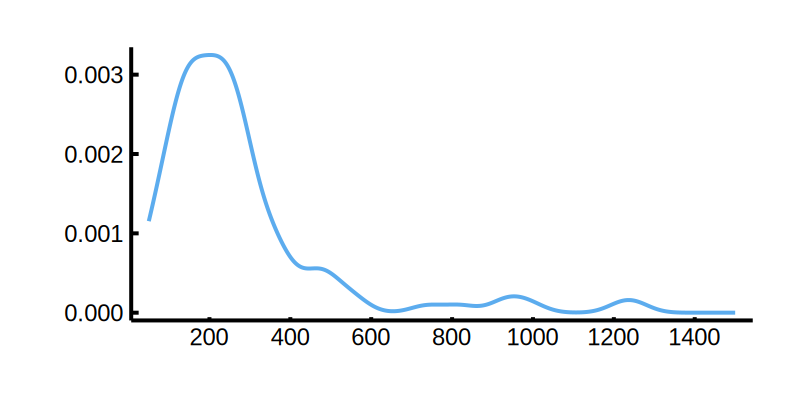

In [1563]:
fig = plot(evals_pts, pdf_H̄r, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("pdf_Hbar_r.png")
fig

In [1564]:
cdf_H̄r = est_cdf(H̄r_bids_obs, evals_pts);

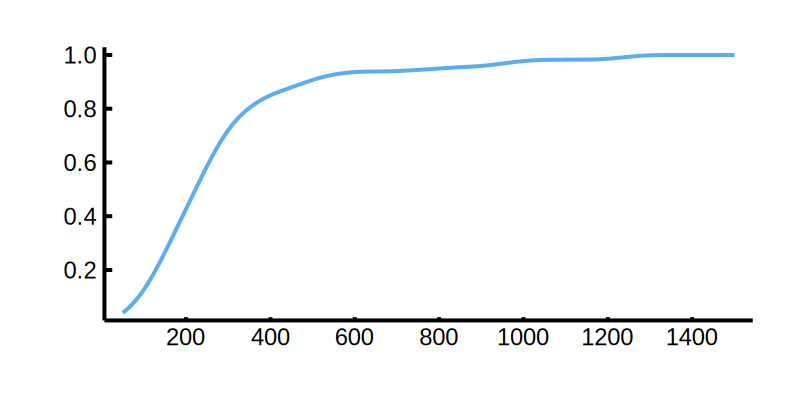

In [1565]:
fig = plot(evals_pts, cdf_H̄r, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("cdf_Hbar_r.png")
fig

### Estimate $G_m$

In [1566]:
#Gm_bids_obs = exp.(dt_b[(dt_b.bidder .!= 100) .& (dt_b.rank .== 1), :b_norm]);
Gm_bids_obs = dt_b[(dt_b.bidder .!= 100) .& (dt_b.rank .== 1), :bhat]
pdf_Gm = est_pdf(Gm_bids_obs, evals_pts);

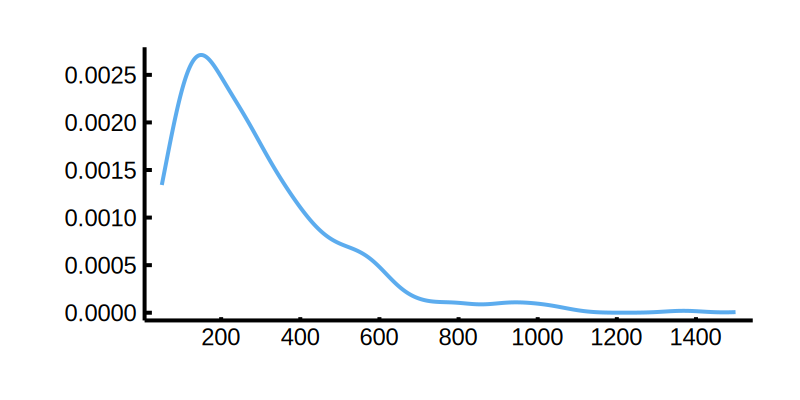

In [1567]:
fig = plot(evals_pts, pdf_Gm, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("pdf_Gm.png")
fig

In [1568]:
cdf_Gm = est_cdf(Gm_bids_obs, evals_pts);

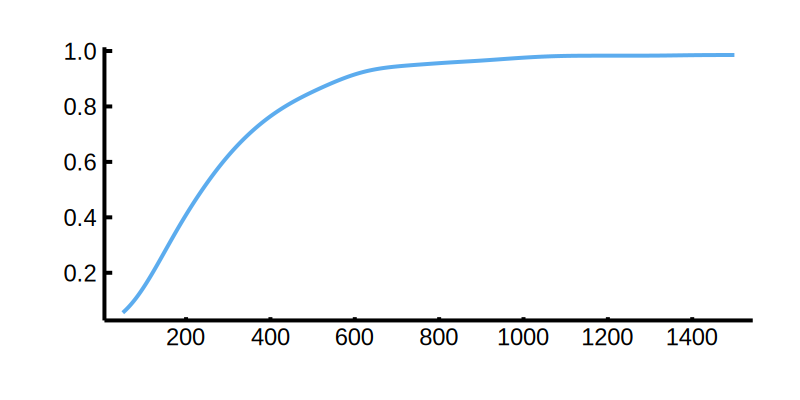

In [1569]:
fig = plot(evals_pts, cdf_Gm, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("cdf_Gm.png")
fig

### Estimate $H_r$

Construct functions for estimation

In [1570]:
max_bid = max(maximum(Gm_bids_obs), maximum(H̄r_bids_obs))
max_bid = 2500

2500

In [1571]:
fn_pdf_h = function(h_bids, g_bids, eval_pts)
    frac(x) = est_pdf(h_bids, x) ./ (1 .- est_cdf(g_bids, x))
    A = (quadgk(frac, 0, max_bid, rtol=1e-4)[1])^(-1)
    return A .* frac.(eval_pts)
end;

In [1572]:
fn_cdf_h = function(h_bids, g_bids, eval_pts)
    frac(x) = est_pdf(h_bids, x) ./ (1 .- est_cdf(g_bids, x))
    A = (quadgk(frac, 0, max_bid, rtol=1e-4)[1])^(-1)
    integral = zeros(length(eval_pts))
    for i in 1:length(integral)
        integral[i] = quadgk(frac, -Inf, 1.0*eval_pts[i], rtol=1e-4)[1]
    end
    return A .* integral
end;

Estimate PDF

In [1573]:
pdf_Hr = fn_pdf_h(H̄r_bids_obs, Gm_bids_obs, evals_pts);

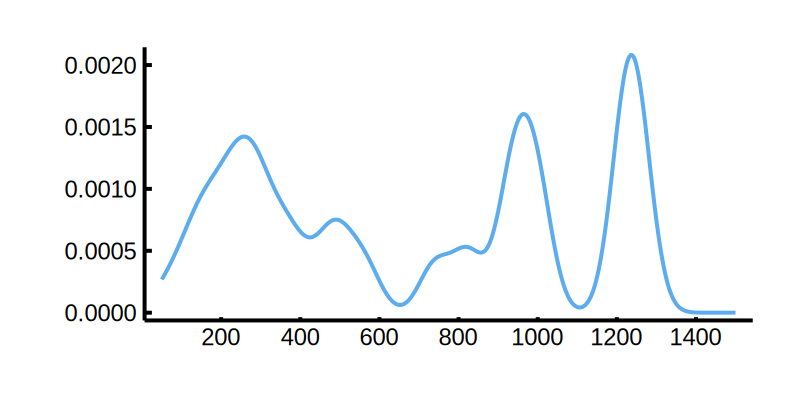

In [1574]:
fig = plot(evals_pts, pdf_Hr, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("pdf_Hr.png")
fig

In [1575]:
cdf_Hr = fn_cdf_h(H̄r_bids_obs, Gm_bids_obs, evals_pts);

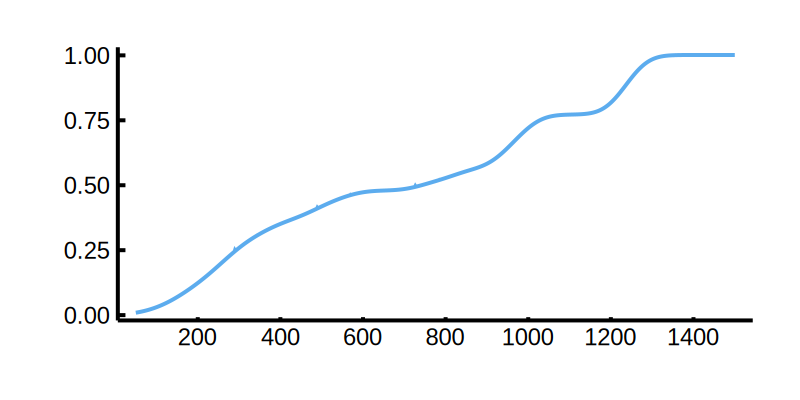

In [1576]:
fig = plot(evals_pts, cdf_Hr, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("cdf_Hr.png")
fig

<br><br><br><br>

## Step 4

### Estimate bid function for each bidder

In [1577]:
bidders = sort(unique(dt.bidder))

pdf_b_i = []
cdf_b_i = [];

In [1578]:
for b in bidders
    bids_i = exp.(dt_b[dt_b.bidder .== b, :b_norm])
    PDF_i(x) = est_pdf(bids_i, x)
    CDF_i(x) = est_cdf(bids_i, x)
    
    push!(pdf_b_i, PDF_i)
    push!(cdf_b_i, CDF_i)
end

### Estimate $\alpha_k$ (participation probabilities)

In [1579]:
all_α_i = []

for b in bidders
    α_i = length(dt_b[dt_b.bidder .== b, :auction_num]) / length(unique(dt_b.auction_num))
    push!(all_α_i, α_i)
end

In [1580]:
round.(all_α_i', digits=3)

1×11 Array{Float64,2}:
 0.571  0.094  0.243  0.08  0.217  0.036  0.036  0.012  0.055  0.007  0.007

### Construct $G_{-i}$

In [1581]:
cdf_b_mi = []

for b in bidders
    bidders_mi = bidders[bidders .!= b]
    
    sum_α_mi = sum(all_α_i[bidders_mi])
    CDF_mi(x) = sum([all_α_i[i] * cdf_b_i[i](x) for i in bidders_mi]) / sum_α_mi
    push!(cdf_b_mi, CDF_mi)
end

In [1582]:
cdf_b_mi[1](500)

0.8295176697674919

### Construct $g_{-i}$

In [1583]:
pdf_b_mi = []

for b in bidders
    bidders_mi = bidders[bidders .!= b]
    
    sum_α_mi = sum(all_α_i[bidders_mi])
    PDF_mi(x) = sum([all_α_i[i] * pdf_b_i[i](x) for i in bidders_mi]) / sum_α_mi
    push!(pdf_b_mi, PDF_mi)
end

In [1584]:
pdf_b_mi[1](500)

0.0009277280135584027

### Construct $v_{ik}$

In [1585]:
eq_2 = function(hr, Hr, gmi, Gmi, b)
    num(x) = 0.5 .* Hr(x) .* (1.0 .- Gmi(x)) 
    denom(x) = hr(x) .* Gmi(x) .+ Hr(x) .* gmi(x)
    return (b .- num(b) ./ denom(b))[1]
end;

In [1591]:
hr(b) = fn_pdf_h(H̄r_bids_obs, Gm_bids_obs, b)
Hr(b) = fn_cdf_h(H̄r_bids_obs, Gm_bids_obs, b)

v_bidders = []

for bid in bidders
    gmi(b) = pdf_b_mi[bid](b)
    Gmi(b) = cdf_b_mi[bid](b)
    
    eq_2_i(b) = eq_2(hr, Hr, gmi, Gmi, b)
    push!(v_bidders, eq_2_i)
end

Check heterogeneity across bidders

In [1592]:
for b in bidders
    println(v_bidders[b](200))
end

146.85660677901325
154.2792881187629
147.07782159067006
152.93056855345074
155.2557781073496
154.42738779454322
152.83527359983776
152.14347649458412
152.99427260893793
152.91590697094878
152.40242863021888


<br><br>

### Figure 2 (strong bidder (1) and then individuals)

In [1593]:
f2_eval = LinRange(0,1250,50);

In [1594]:
values_b_1 = v_bidders[1].(f2_eval);
#values_b_1 = values_b_1[values_b_1 .> 250];

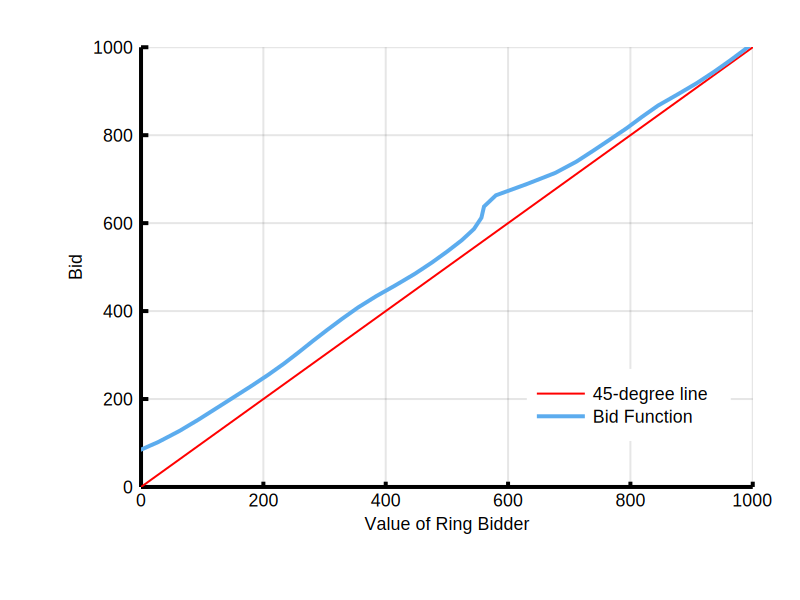

In [1595]:
fig = plot(LinRange(0,1500,2), LinRange(0,1500,2), linecolor=:red, linewidth=0.5, lab="45-degree line")
plot!(values_b_1, f2_eval, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(3), ytickfont=font(3), legend=:bottomright, yticks=[0:200:1000;], ylims=(0,1000),
        xticks=[0:200:1000;], xlims=(0,1000), lab="Bid Function", xlab="Value of Ring Bidder",
        legendfont=font(3), guidefont=font(3), ylab="Bid",
        foreground_color_legend=:white, background_color_legend=:white, grid=true)
plot!(size=(200,150))
savefig("Fig_2_b_1.png")
fig

In [1596]:
values_b = []
for b in bidders
    push!(values_b, v_bidders[b].(f2_eval))
end

In [1597]:
figs_i = []
for b in bidders
    fig = plot(LinRange(0,1500,2), LinRange(0,1500,2), linecolor=:red, linewidth=0.5, lab="45-degree line")
    plot!(values_b_1, f2_eval, linecolor=:steelblue2, linewidth=1, 
            xtickfont=font(3), ytickfont=font(3), legend=:bottomright, yticks=[0:200:1000;], ylims=(0,1000),
            xticks=[0:200:1000;], xlims=(0,1000), lab="Bid Function", xlab="Value of Ring Bidder",
            legendfont=font(3), guidefont=font(3), ylab="Bid",
            foreground_color_legend=:white, background_color_legend=:white, grid=true)
    plot!(size=(200,150))
    savefig("Fig_2_b_" * string(b) * ".png")
    push!(figs_i, fig)
end

Check individual bidding functions (there are few differences across bidders, so this is commented out)

"Bidder 1"

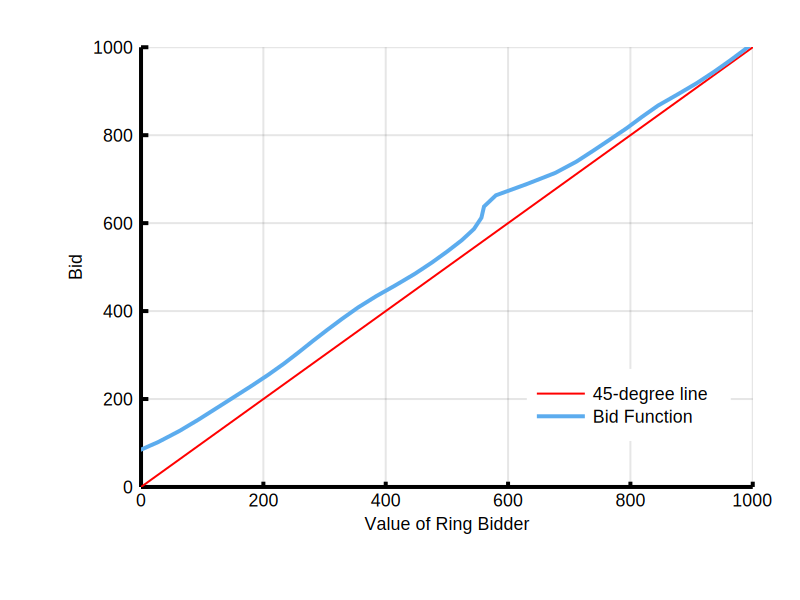

"Bidder 2"

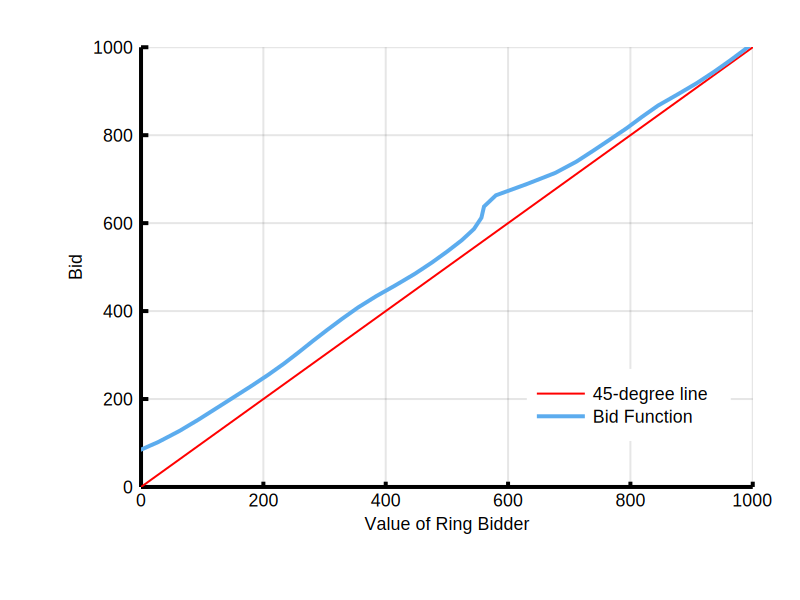

"Bidder 3"

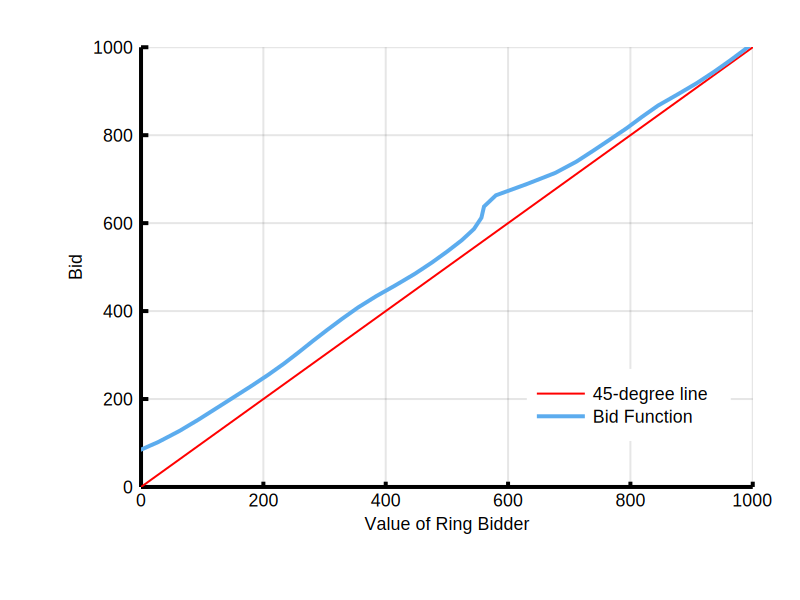

"Bidder 4"

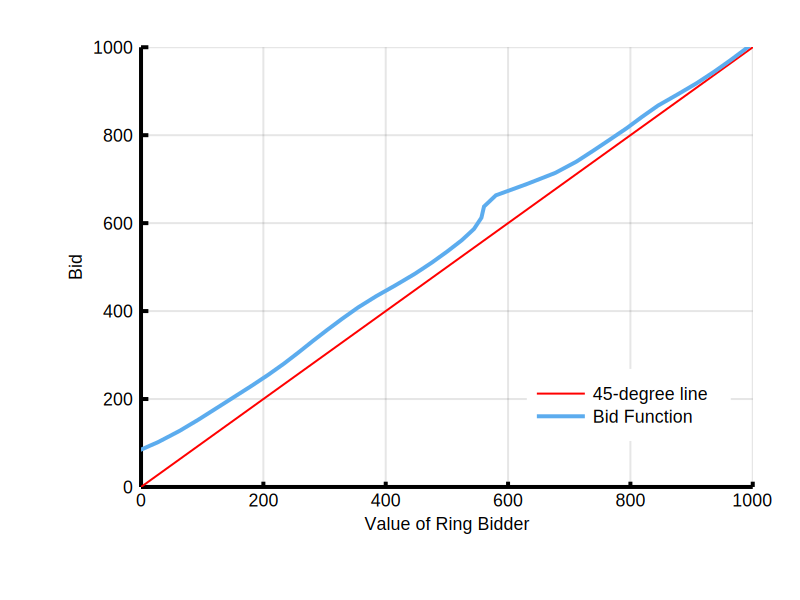

"Bidder 5"

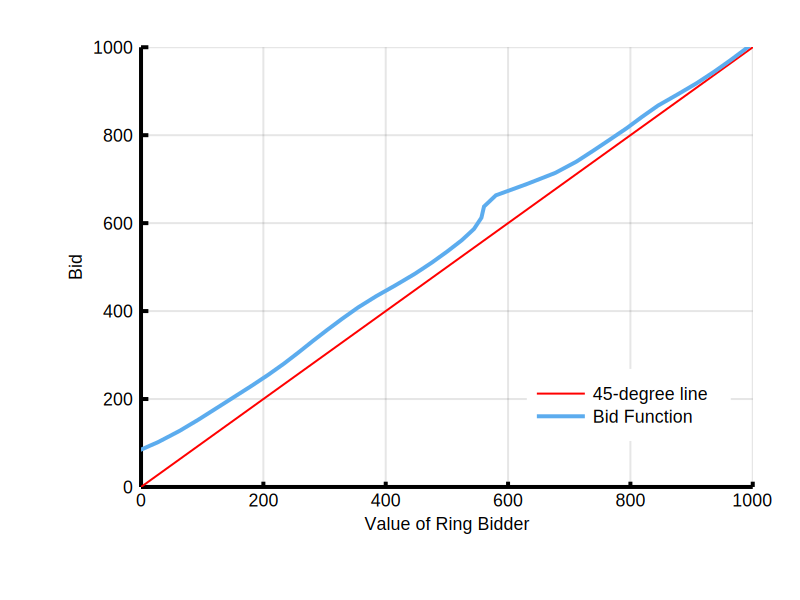

"Bidder 6"

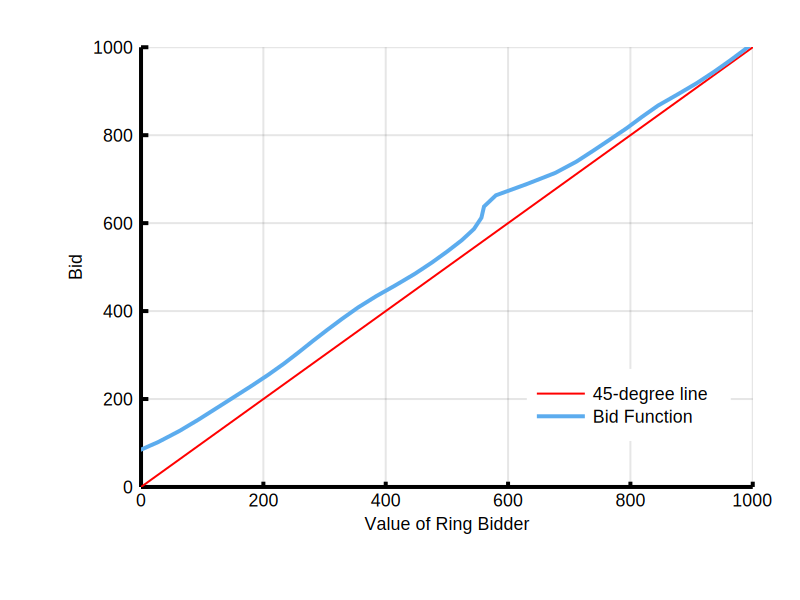

"Bidder 7"

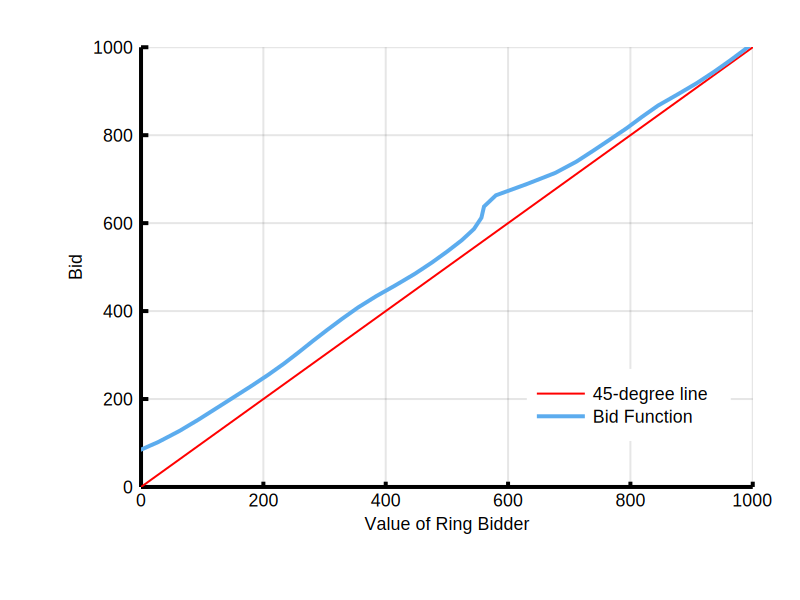

"Bidder 8"

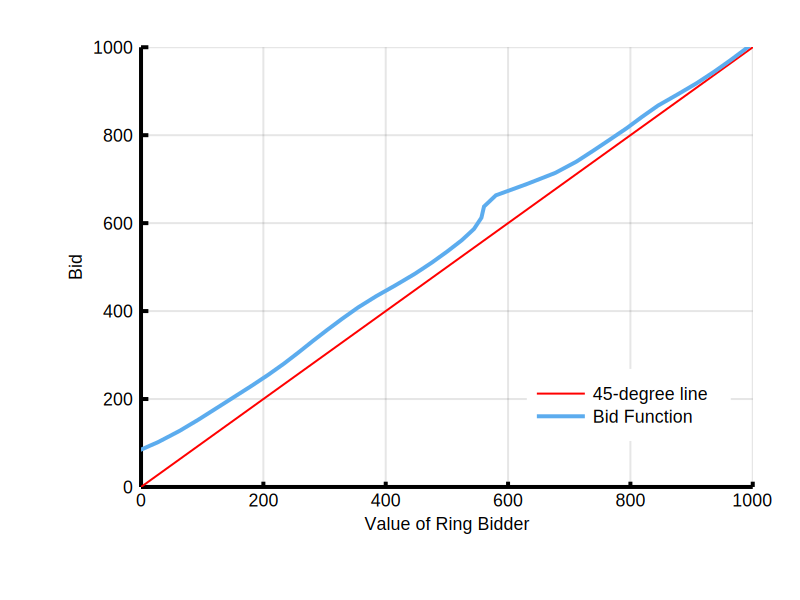

"Bidder 9"

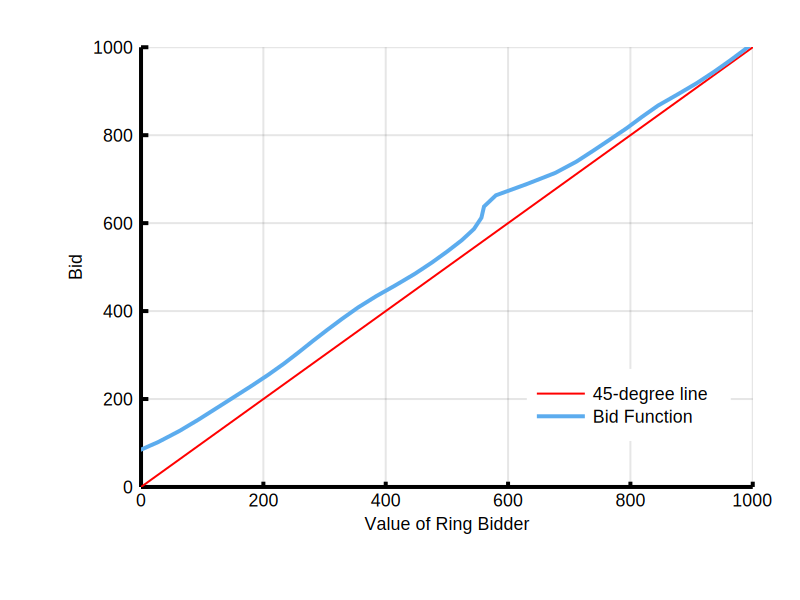

"Bidder 10"

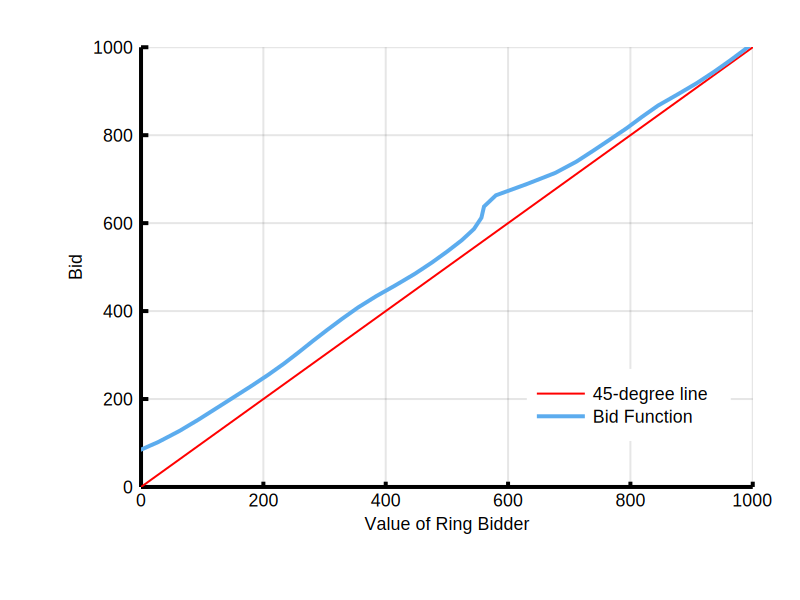

"Bidder 11"

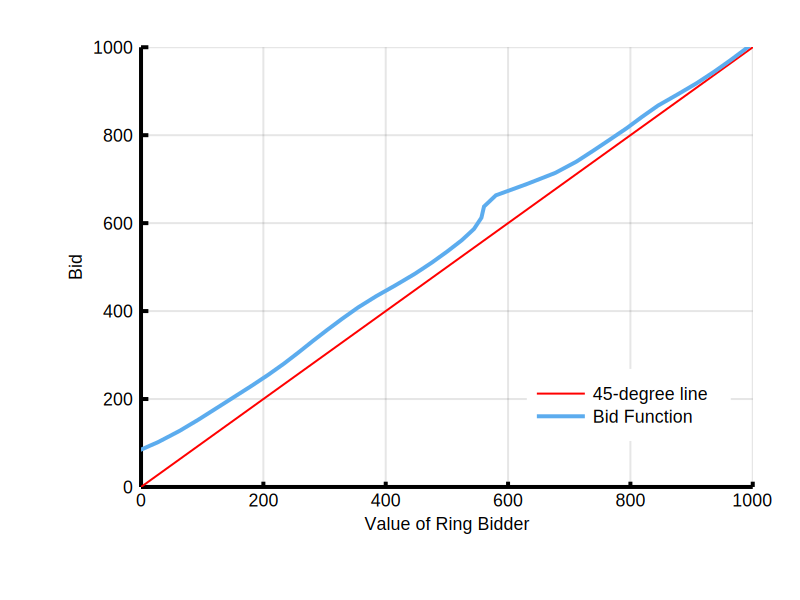

In [1598]:
for b in bidders
    display("Bidder " * string(b))
    display(figs_i[b])
end